<a href="https://colab.research.google.com/github/yohanesnuwara/pyreservoir/blob/master/notebooks/oil_reservoir_drive_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!git clone https://github.com/yohanesnuwara/pyreservoir

Cloning into 'pyreservoir'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 373 (delta 73), reused 0 (delta 0), pack-reused 234
Receiving objects: 100% (373/373), 475.72 KiB | 683.00 KiB/s, done.
Resolving deltas: 100% (195/195), done.


In [3]:
import sys

sys.path.append('/content/pyreservoir/pvt')
from pvtlab import linear_interpolate

sys.path.append('/content/pyreservoir/matbal')
from aquifer import schilthuis, veh, fetkovich

sys.path.append('/content/pyreservoir/matbal')
from drives import saturated_nonvolatile_totaloil, energy_plot

### Part 1. Processing Production and PVT Data

In [4]:
# load production data
columns = ['date', 'p', 'Np', 'Wp', 'Wi', 'Wp-Wi', 'Gp']
df = pd.read_csv('/content/pyreservoir/data/conroe_proddata.csv', names=columns)

# load PVT data
columns = ['p', 'Bg', 'Bt']
pvt = pd.read_csv('/content/pyreservoir/data/conroe_pvtdata.csv', names=columns)

# define variables in PVT data
p, Bg, Bt = pvt['p'].values, pvt['Bg'].values, pvt['Bt'].values

# define variables in production data
p1 = df['p'].values

# interpolate Bg and Bt from PVT to production data
Bg_interpolated = linear_interpolate(p, p1, Bg)
Bt_interpolated = linear_interpolate(p, p1, Bt)

# add the interpolated Bg and Bt data into production dataframe
df['Bg'] = Bg_interpolated
df['Bt'] = Bt_interpolated

# convert time column to datetime
df['date'] =  pd.to_datetime(df['date'], format='%d %B %Y')

# define input variables
t = df['date'].values
p = df['p'].values
Np = df['Np'].values
Wp = df['Wp'].values
Wi = df['Wi'].values
Gp = df['Gp'].values * 1E+3 # convert to SCF  
Bg = df['Bg'].values * (1 / 1E+3) # convert to RB/SCF
Bt = df['Bt'].values
Bw = np.full(len(df), 1) # Water FVF is made constant, 1 RB/STB

df.head(10)

,date,p,Np,Wp,Wi,Wp-Wi,Gp,Bg,Bt
0,1932-01-01,2180.0,0.0,0.0,0.0,0.0,0.0,1.187000,1.205000
1,1932-07-01,2177.0,1341096.0,0.0,0.0,0.0,3330412.0,1.188875,1.205563
2,1933-01-01,2170.0,2681691.0,0.0,0.0,0.0,6412824.0,1.193250,1.206875
3,1933-07-01,2148.0,9784770.0,0.0,0.0,0.0,14900678.0,1.206469,1.211265
4,1934-01-01,2125.0,23440301.0,0.0,0.0,0.0,24295374.0,1.220082,1.215959
5,1934-07-01,2110.0,32325186.0,0.0,0.0,0.0,30585954.0,1.229000,1.219100
6,1935-01-01,2103.0,39819896.0,71470.0,0.0,71470.0,35940966.0,1.233200,1.220640
7,1935-07-01,2105.0,47414017.0,143243.0,0.0,143243.0,41313677.0,1.232000,1.220200
8,1936-01-01,2096.0,54185666.0,188180.0,0.0,188180.0,46221132.0,1.237400,1.222180
9,1936-07-01,2089.0,61129694.0,346001.0,0.0,346001.0,50923634.0,1.241600,1.223720


### Part 2. Calculate Aquifer Influx

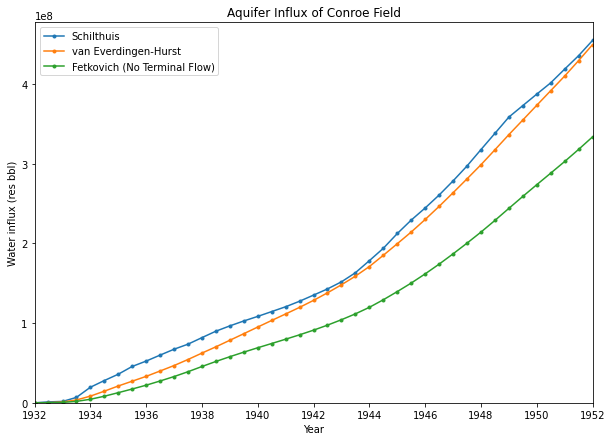

In [5]:
# all known data of Conroe field
Nfoi = 800.44 * 1E+6 # OOIP from volumetrics, STB
Gfgi = 350 * 1E+9 # Original gas cap volume from volumetrics, SCF
Rsi = 600 # SCF/STB
Boi = 1.205 # Original oil FVF, RB/STB
Bgi = 1.187 * (1 / 1E+3) # Original gas FVF, convert to RB/SCF
Vwi = 20 * 1E+6 # Interstitial water volume, bbl
hsand = 200 # Gross sand thickness, ft
poro = 0.28
re = 6600 # Reservoir radius, ft
r_aq = 264000 # Aquifer radius, ft
k = 265 # Permeability, md
cw = 3.4E-6 # Water compressibility, sip
cf = 3.4E-6 # Formation compressibility, sip
mu_w = 0.38 # Water viscosity, cp

# calculate Swi from hsand, poro, and Vwi
Vbulk = np.pi * (re**2) * hsand # ft3
PV = poro * Vbulk # pore volume, ft3
Vwi = Vwi * 5.6145 # convert to ft3
swi = Vwi / PV

# calculate aquifer influx 
import sys
sys.path.append('/content/pyreservoir/matbal')
from aquifer import *

## Schilthuis
method = schilthuis()
We_schilthuis = We_schilthuis = schilthuis.calculate_aquifer(method, p, Bw, Wp, Np, Bt, Nfoi, cf, cw, swi, Bt[0])

## VEH
method = veh()
B_star = veh.calculate_aquifer_constant(method, re, hsand, cf, cw, poro)
We_veh = veh.calculate_aquifer(method, t, p, cf, cw, k, poro, mu_w, re, B_star)

## Fetkovich
method = fetkovich()
ct = cf + cw
theta = 360
Wei = fetkovich.initial_encroachable_water(method, p[0], ct, re, r_aq, hsand, poro, theta)
J = fetkovich.productivity_index(method, k, hsand, mu_w, r_aq, re, theta, flow='no flow')
We_fetkovich = fetkovich.calculate_aquifer(method, t, p, Wei, J)

# plot the aquifer influx
plt.figure(figsize=(10,7))
plt.plot(t, We_schilthuis, '.-', label='Schilthuis')
plt.plot(t, We_veh, '.-', label='van Everdingen-Hurst')
plt.plot(t, We_fetkovich, '.-', label='Fetkovich (No Terminal Flow)')
plt.title('Aquifer Influx of Conroe Field')
plt.xlabel('Year')
plt.ylabel('Water influx (res bbl)')
plt.xlim(min(t), max(t)); plt.ylim(ymin=0)

plt.legend()
plt.show()


### Part 3. Calculate Pirson Drive Indices and Display Energy Plot

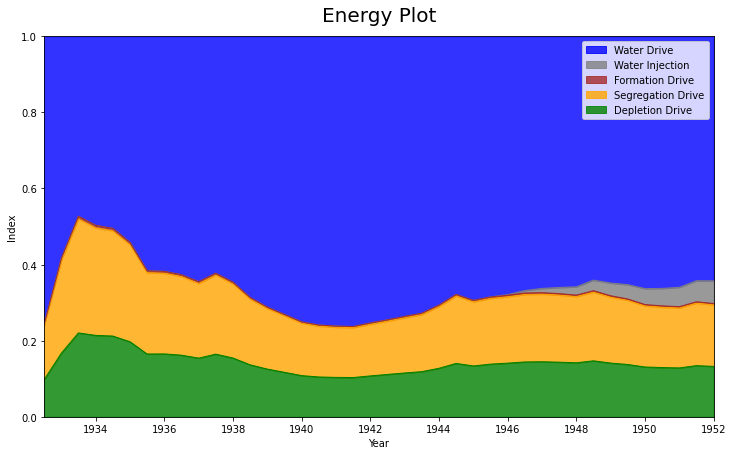

In [8]:
# initialize with type: saturated_nonvolatile_totaloil
type = saturated_nonvolatile_totaloil()

# calculate material balance parameters
F, Efw, Eo, Eg = saturated_nonvolatile_totaloil.calculate_params(type, p, Bg, Bt, Rsi, Np, Gp, cf, cw, swi)

# calculate drive indices
Idd, Isd, Ifd, Iwd, Iwi = saturated_nonvolatile_totaloil.indices(type, F, Efw, Eo, Eg, Nfoi, Gfgi, Boi, Bgi, We_schilthuis, Bw, Wp, Wi)

# display energy plot
energy_plot(t, Idd, Isd, Ifd, Iwi)
